<a href="https://colab.research.google.com/gist/maya2d26/d91b2f40187e27a71933710c43671920/finalmilestone_vgg_gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Python és LUA alapokon -  Homework -Final**


---

**Group name : * *Rise of AI* ***

Group Members: Tugyi Beatrix (T63K63), El-Ali Maya (BHI5LF), Simkó Máté (O3BMRX)

**Chosen task: Face Recognition and Generation**

**Dataset: [FairFace Datset](https://github.com/joojs/fairface)**

#Imports

In [ ]:
!pip install torchmetrics
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

import dlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from PIL import Image
import torch.nn.functional as F

from torchmetrics import Accuracy
from torchmetrics.classification import MultilabelAccuracy

from tqdm.notebook import tqdm #a progress bar for aesthetic training visualisation
import torchvision.models as models #for the models used in transfer learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 40.1 MB/s 


#Loading the data

In [ ]:
# getting the images
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86" -O data.zip && rm -rf /tmp/cookies.txt

--2022-12-11 15:58:04--  https://docs.google.com/uc?export=download&confirm=t&id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86
Resolving docs.google.com (docs.google.com)... 142.250.4.139, 142.250.4.101, 142.250.4.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.4.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/orusgu4itcgm0rn2voci9i9oqvt7pnlg/1670774250000/03161587497725415728/*/1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86?e=download&uuid=33a7ecbf-cd15-492c-9d6a-7d7b0a2923b4 [following]
--2022-12-11 15:58:04--  https://doc-0g-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/orusgu4itcgm0rn2voci9i9oqvt7pnlg/1670774250000/03161587497725415728/*/1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86?e=download&uuid=33a7ecbf-cd15-492c-9d6a-7d7b0a2923b4
Resolving doc-0g-64-docs.googleusercontent.com (doc-0g-64-docs.googleusercontent.com)... 74.125.68.132, 2404:

In [ ]:
# getting the training labels
! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH' -O "fairface_label_train.csv"

--2022-12-11 15:58:15--  https://docs.google.com/uc?export=download&id=1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH
Resolving docs.google.com (docs.google.com)... 142.250.4.139, 142.250.4.101, 142.250.4.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.4.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ahd94n3f6g9aaq6lu5i051qk04k0l7tg/1670774250000/03161587497725415728/*/1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH?e=download&uuid=99873a30-6a2b-4504-85b4-ed63a256e81b [following]
--2022-12-11 15:58:17--  https://doc-04-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ahd94n3f6g9aaq6lu5i051qk04k0l7tg/1670774250000/03161587497725415728/*/1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH?e=download&uuid=99873a30-6a2b-4504-85b4-ed63a256e81b
Resolving doc-04-64-docs.googleusercontent.com (doc-04-64-docs.googleusercontent.com)... 74.125.68.132, 2404:6800:4003:

In [ ]:
# getting the validation labels
! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D' -O "fairface_label_val.csv"

--2022-12-11 15:58:18--  https://docs.google.com/uc?export=download&id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D
Resolving docs.google.com (docs.google.com)... 142.250.4.139, 142.250.4.101, 142.250.4.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.4.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7vkuimkp5cn5lkjkbfhkvci6hibo7cob/1670774250000/03161587497725415728/*/1wOdja-ezstMEp81tX1a-EYkFebev4h7D?e=download&uuid=6c39f526-b6b2-45b7-b839-dc6f11ed8a69 [following]
--2022-12-11 15:58:19--  https://doc-08-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7vkuimkp5cn5lkjkbfhkvci6hibo7cob/1670774250000/03161587497725415728/*/1wOdja-ezstMEp81tX1a-EYkFebev4h7D?e=download&uuid=6c39f526-b6b2-45b7-b839-dc6f11ed8a69
Resolving doc-08-64-docs.googleusercontent.com (doc-08-64-docs.googleusercontent.com)... 74.125.68.132, 2404:6800:4003:

In [ ]:
#unzip the images
! unzip  *data.zip

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: val/5370.jpg            
  inflating: val/5596.jpg            
  inflating: val/5875.jpg            
  inflating: val/5878.jpg            
  inflating: val/5879.jpg            
  inflating: val/5883.jpg            
  inflating: val/6126.jpg            
  inflating: val/6132.jpg            
  inflating: val/6144.jpg            
  inflating: val/6150.jpg            
  inflating: val/6340.jpg            
  inflating: val/7190.jpg            
  inflating: val/7734.jpg            
  inflating: val/7747.jpg            
  inflating: val/7872.jpg            
  inflating: val/7940.jpg            
  inflating: val/8065.jpg            
  inflating: val/8069.jpg            
  inflating: val/8125.jpg            
  inflating: val/8202.jpg            
  inflating: val/8204.jpg            
  inflating: val/8205.jpg            
  inflating: val/8268.jpg            
  inflating: val/8270.jpg            
  inflating: val/8281.jpg            

In [ ]:
#number of training images
! ls train | wc -l

86744


In [ ]:
#number of validation images
! ls val | wc -l

10954


#**Data Preprocessing**

In [ ]:
#for encoding multiclass labels
def one_hot_df(df,target):
  if(target != 'multi'):
    label = df[target]
    label= pd.get_dummies(label)
    return pd.concat([label], axis=1)
  
  age = df['age']
  age = pd.get_dummies(age)
  race = df['race']
  race = pd.get_dummies(race)
  gender = df['gender']
  gender = pd.get_dummies(gender)
   
  return pd.concat([age,gender,race], axis=1)

#for encoding binary labels
def to_categorical(df,target):

  df[target] = df[target].astype('category')
  df[target] = df[target].cat.codes

  return df

#for encoding the given target label
def encode_target(train,valid,test,target):
  if(target == "gender"):
    Y_train = to_categorical(train,target)
    Y_valid = to_categorical(valid,target)
    Y_test = to_categorical(test,target)
  elif(target == "multi"):
    Y_train = one_hot_df(train,target)
    Y_valid = one_hot_df(valid,target)
    Y_test = one_hot_df(test,target)
  elif(target == "race" or target == "age"):
    Y_train = one_hot_df(train,target)
    Y_valid = one_hot_df(valid,target)
    Y_test = one_hot_df(test,target)
  return Y_train, Y_valid, Y_test

In [ ]:
def preprocess(target="multi"):
  #loading the labels
  train_df = pd.read_csv("fairface_label_train.csv")
  train_df = train_df.drop(['service_test'], axis=1)
 # train_df = train_df[:10000]
  print("Number of all training images: " + str(len(train_df)))
  valid_df = pd.read_csv("fairface_label_val.csv")
  valid_df = valid_df.drop(["service_test"], axis = 1)
  #valid_df = valid_df[:2000]
  print("Number of validation images: " + str(len(valid_df)))
  #splitting the data
  print("Splitting the data...")
  #training with only one label
  if(target != "multi"):
    train_x = train_df.loc[:, train_df.columns == "file"]
    train_y = train_df.loc[:, train_df.columns == target]
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify = train_y)
    print("Number of training images: " + str(len(X_train_raw)))
    print("Number of test images: " + str(len(X_test_raw)))
    valid_x = valid_df.loc[:, valid_df.columns == "file"]
    valid_y = valid_df.loc[:, valid_df.columns == target]
  # multi label training
  else:
    train_x = train_df.loc[:, train_df.columns == "file"]
    train_y = train_df.loc[:, train_df.columns != "file"]
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify = train_y)
    print("Number of training images: " + str(len(X_train_raw)))
    print("Number of test images: " + str(len(X_test_raw)))
    valid_x = valid_df.loc[:, valid_df.columns == "file"]
    valid_y = valid_df.loc[:, valid_df.columns != "file"]
  #encoding the data
  print("Encoding target labels...")
  Y_train_, Y_valid_, Y_test_ = encode_target(y_train_raw, valid_y, y_test_raw, target)
  #When creating the test dataset using train_test_split, the indeces were also scrambled, so they need to be renumbered
  X_train_ = X_train_raw.reset_index(drop=True)
  Y_train_ = Y_train_.reset_index(drop=True)
  X_test_ = X_test_raw.reset_index(drop=True)
  Y_test_ = Y_test_.reset_index(drop=True)
  #renaming variable
  X_valid_ = valid_x
  print("Preprocessing finished!")
  return X_train_, Y_train_, X_valid_, Y_valid_, X_test_, Y_test_


#**Create a DataLoader for the images**

In [ ]:
#Defining our own dataset
class FaceRecognitionDataset(Dataset):  
    def __init__(self, image_ds, label_ds, transform=None):
        self.label_ds = label_ds
        self.ds = image_ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img = dlib.load_rgb_image(self.ds["file"][idx])
        img = torchvision.transforms.ToPILImage()(img)
        label = self.label_ds.iloc[idx]
        label = torch.tensor(label)
        if self.transform:
            img = self.transform(img)  
            return img, label

In [ ]:
# Trasformation of the Images
# On the train set: We Crop, Flip and Rotate and we transform both the train, test and valid datasets to tensors

train_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

val_and_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

#Set GPU usage

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    torch.device('cpu')
#CUDA check
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl 
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

#**Train Functions**

In [ ]:
#custom accuracy
def accuracy(preds, labels): 
    #for non-binary labels
    if(preds.shape[1]!=1): 
      _, preds = torch.max(preds, dim=1)
      _, labels = torch.max(labels, dim=1)
    #for multi labels
    elif(preds.shape[1] == 18):
      # predictions
      age_preds, gender_preds,race_preds = torch.split(preds, [9,2,7], dim=1)
      _, age_preds = torch.max(age_preds, dim=1)
      _, race_preds = torch.max(race_preds, dim=1)
      _, gender_preds = torch.max(gender_preds, dim=1)

      # labels
      age_labels, gender_labels,race_labels = torch.split(labels, [9,2,7], dim=1)
      _, age_labels = torch.max(age_labels, dim=1)
      _, race_labels = torch.max(race_labels, dim=1)
      _, gender_labels = torch.max(gender_labels, dim=1)

      # accuracy
      age_acc = torch.tensor(torch.sum(age_preds == age_labels).item() / len(age_preds))
      race_acc = torch.tensor(torch.sum(race_preds == race_labels).item() / len(race_preds))
      gender_acc = torch.tensor(torch.sum(gender_preds == gender_labels).item() / len(gender_preds))

      accs = [age_acc, race_acc, gender_acc]

      print(accs)
      return torch.mean(torch.tensor(accs, dtype = torch.float))
    #for gender prediction
    else:
      preds = torch.round(preds)  
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        targets = targets.type(torch.float32)
    
        if(out.shape[1] == 1):
          loss_fn = nn.BCELoss() 
        else: 
          loss_fn = nn.CrossEntropyLoss()

        loss = loss_fn(out, targets) 
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        targets = targets.type(torch.float32)
        out = self(img)
        if(out.shape[1] == 1):
          loss_fn = nn.BCELoss() 
        else: 
          loss_fn = nn.CrossEntropyLoss()
             
        loss = loss_fn(out, targets) 
        targets = targets.type(torch.int32)
     
        acc = accuracy(out, targets)
        return {'val_acc':acc,  'val_loss':loss}
    
    # validation step at the end of the epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
       
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}


    # Printing the results at the end of the epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}"
        .format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))

In [ ]:
# Defining the model
class FaceClassificationModel(ImageClassificationBase):
    def __init__(self, num_classes, h, base_model):
        super().__init__()       
        if base_model == "ResNet":
            self.network = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
        else:
            self.network = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
        if (num_classes == 1):
           self.activation = nn.Sigmoid()
        else:
          self.activation = nn.Softmax(1)

        if base_model == "ResNet":
          num_ftrs = self.network.fc.in_features
          self.network.fc = nn.Sequential(
              nn.Linear(num_ftrs, h),
              nn.ReLU(inplace=True),
              nn.Linear(h,num_classes),  # for the n output
              self.activation
          )
        else:
           num_ftrs = 25088
           self.network.classifier = nn.Sequential(
              nn.Linear(num_ftrs, 4096),
              nn.ReLU(inplace=True),
              nn.Dropout(p=0.5),
              nn.Linear(4096, 4096),
              nn.ReLU(inplace=True),
              nn.Dropout(p=0.5),
              nn.Linear(4096, num_classes),
              self.activation
         )
    def forward(self, xb):
        return self.network(xb)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def fit_one_cycle(epochs, max_lr, model, target, batch_size, weight_decay, grad_clip, opt_func):
    # preprocessing and creating data loaders
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = preprocess(target)
    train_dataset = FaceRecognitionDataset(X_train, Y_train, train_transform)
    val_dataset = FaceRecognitionDataset(X_valid, Y_valid, val_and_test_transform)
    train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_dl = DataLoader(val_dataset, batch_size, num_workers=2, pin_memory=True)
    train_dl = DeviceDataLoader(train_dl, device)
    val_dl = DeviceDataLoader(val_dl, device)

    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # setting the learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
    for epoch in range(epochs):      
        # Training
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_dl):
            loss = model.training_step(batch)
            train_losses.append(loss)       
            # Gradient backpropogation
            loss.backward()            
            # Gradient clipping if needed
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)              
            # Performing gradient descent -> recalculating weights
            optimizer.step()           
            # Reset gradients
            optimizer.zero_grad()         
            # Save, update learning rate
            lrs.append(get_lr(optimizer))          
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
             
    return history

# For evaluating the test and the validation datasets -> no gradient calculation
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# For prediction
@torch.no_grad()
def predict(model, test_loader, target):
  preds = [model(img) for img, targets in test_loader]
  preds = [pred.cpu().detach().numpy() for pred in preds]
  if(target != "gender"):
    preds = [np.argmax(pred, axis=-1) for pred in preds]    #non-binary classification - argmax on predictions
  else:
    preds = [np.round(pred) for pred in preds]              #binary classification - rounding predictions
  preds = [item for sublist in preds for item in sublist] 
  return preds

# **You can choose the type here!**

In [ ]:
target = "gender" #, "gender", "multi", "race"

In [ ]:
#initialise mode
if target == "multi":
  num_classes = 18
elif target == "gender":
   num_classes = 1
elif target == "age":
   num_classes = 9
else:
   num_classes = 7


#Hyperparameter

In [ ]:
#set hiperparameters

opt_func = [torch.optim.SGD]
max_lr = [ 0.001]
grad_clip = [0.1, 0.2] #0
weight_decay = [1e-4, 1e-5]
batch_size = [16, 32]
hidden_size = [ 128, 256]

In [ ]:
base_model = "VGG" #, 'VGG'
num_epochs = 3

In [ ]:
# for hyperparameter optimising
def run(opt, lr, gc, wd, batch, h):
    Model = FaceClassificationModel(num_classes, h, base_model)
    to_device(Model, device)
    history_RN = fit_one_cycle(num_epochs, lr, Model, target, batch, wd, gc, opt)
    return  history_RN

In [ ]:
# optimising
results = []
for opt in opt_func:
  for lr in max_lr:
    for gc in grad_clip:
      for wd in weight_decay:
        for batch in  batch_size:
           for h in  hidden_size:
            acc = run(opt, lr, gc, wd, batch, h)
            results.append([acc, opt, lr, gc, wd, batch, h])
            print(acc, opt, lr, gc, wd, batch, h)

# Training

In [ ]:
#set hiperparameters

num_epochs = 10
opt_func = torch.optim.SGD
max_lr = 0.005
grad_clip = 0.1
weight_decay = 0.0001
batch_size = 32
hidden_size = 128
base_model = "VGG" #, 'VGG'


In [ ]:
Model = FaceClassificationModel(num_classes, hidden_size , base_model)
to_device(Model, device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

FaceClassificationModel(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
history_RN = fit_one_cycle(num_epochs, max_lr, Model, target, batch_size, 
                           weight_decay, grad_clip, opt_func)

Number of all training images: 86744
Number of validation images: 10954
Splitting the data...
Number of training images: 78069
Number of test images: 8675
Encoding target labels...
Preprocessing finished!


<ipython-input-8-b3324e4251f3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].astype('category')
<ipython-input-8-b3324e4251f3>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].cat.codes


  0%|          | 0/2440 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.3893, val_loss: 0.2740, val_acc: 0.8765


  0%|          | 0/2440 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.2712, val_loss: 0.2544, val_acc: 0.8900


  0%|          | 0/2440 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.2388, val_loss: 0.2298, val_acc: 0.9013


  0%|          | 0/2440 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.2119, val_loss: 0.2016, val_acc: 0.9143


  0%|          | 0/2440 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.1909, val_loss: 0.2006, val_acc: 0.9114


  0%|          | 0/2440 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.1728, val_loss: 0.1950, val_acc: 0.9208


  0%|          | 0/2440 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.1545, val_loss: 0.1828, val_acc: 0.9243


  0%|          | 0/2440 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.1319, val_loss: 0.1865, val_acc: 0.9250


  0%|          | 0/2440 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.1013, val_loss: 0.1894, val_acc: 0.9290


  0%|          | 0/2440 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.0783, val_loss: 0.1960, val_acc: 0.9319


#Visualize History

In [ ]:
# get the data about the training
import matplotlib.pyplot as plt
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history_RN)))
for h in history_RN:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

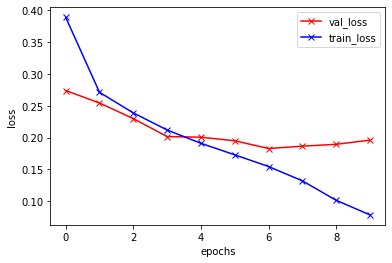

In [ ]:
# plotting the loss
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

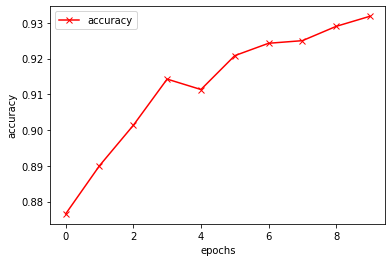

In [ ]:
# plotting the accuracy

plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#Save the model

In [ ]:
import datetime

torch.save(Model, 'VGG_'+target+'_'+str(datetime.datetime.now())+'.pth')

#Evaluation

In [ ]:
#load the model if needed
saved = torch.load('ResnetModel_gender.pth')

In [ ]:
#reset target id needed
target = "gender"
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = preprocess(target)
#Creating the datasets
train_dataset = FaceRecognitionDataset(X_train, Y_train, train_transform) 
val_dataset = FaceRecognitionDataset(X_valid, Y_valid, val_and_test_transform)
test_dataset = FaceRecognitionDataset(X_test, Y_test, val_and_test_transform)
#Create the dataloaders
batch_size = 32
num_workers = 2
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size, num_workers=num_workers, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size, num_workers=num_workers, pin_memory=True)
#Creating the dataloaders on the used device
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

Number of all training images: 86744
Number of validation images: 10954
Splitting the data...
Number of training images: 78069
Number of test images: 8675
Encoding target labels...
Preprocessing finished!


<ipython-input-8-b3324e4251f3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].astype('category')
<ipython-input-8-b3324e4251f3>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].cat.codes


In [ ]:
# calculate accuracy
result = evaluate(Model, test_dl)
print("Test loss: " ,result['val_loss'])
print("Test accuracy: ",result['val_acc'])

Test loss:  0.18735623359680176
Test accuracy:  0.9331341981887817


In [ ]:
preds = predict(Model, test_dl, target)

In [ ]:
labels = [targets for img,targets in test_dl]
labels = [label.cpu().detach().numpy() for label in labels]
if (target != "gender"):
  labels = [np.argmax(label, axis=-1) for label in labels]
labels = [item for sublist in labels for item in sublist] 

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      4076
           1       0.93      0.94      0.94      4599

    accuracy                           0.93      8675
   macro avg       0.93      0.93      0.93      8675
weighted avg       0.93      0.93      0.93      8675



In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(labels, preds)
print(cf_matrix)

[[3760  316]
 [ 266 4333]]


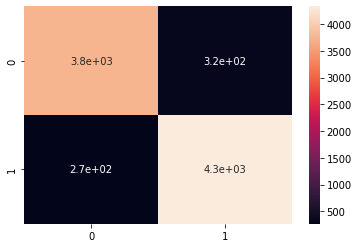

In [ ]:
import seaborn as sns

sns.heatmap(cf_matrix, annot=True)